**DAT341 Applied machine learning**
*Programming assignment 3: Stance Classification*

Group members (PA 3 65) :
*   Ranjitha Ranganathan
*   Puthige Venugopal Chetan Acharya
*   Filip Hanberg

In [ ]:
# DATA PRE-PROCESSING
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Reading the data
def read_data(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'comment'])
    return data

# Filter consistent annotations
# Discards data which has inconsistent annotations like 0/1, 0/-1, 1/0/1 etc.. 
def filter_consistent_annotations(data):
    consistent_data = data[data['label'].apply(lambda x: len(set(x.split('/'))) == 1)].copy()
    consistent_data.loc[:, 'label'] = consistent_data['label'].apply(lambda x: int(x.split('/')[0]))
    return consistent_data

# Preprocess data
def preprocess_data(data):
    data = data.copy()  # Make a copy to avoid modifying the original DataFrame

    # Convert text to lowercase
    data.loc[:, 'comment'] = data['comment'].str.lower()

    # Remove numbers
    data.loc[:, 'comment'] = data['comment'].str.replace(r'\d+', '', regex=True)

    # Remove punctuation
    data.loc[:, 'comment'] = data['comment'].str.replace(r'[^\w\s]', '', regex=True)
    
    # Remove emojis
    data.loc[:, 'comment'] = data['comment'].apply(lambda x: ''.join(c for c in x if c not in map(chr, range(0x1F600, 0x1F650))))

    return data

file_path = "a3_train_final.tsv"
data = read_data(file_path)
total_rows_before = len(data)
print("\nTotal number of training rows :", total_rows_before )
consistent_data = filter_consistent_annotations(data)
preprocessed_data = preprocess_data(consistent_data)
print(preprocessed_data.head())
total_rows_after = len(consistent_data)
rows_deleted = total_rows_before - total_rows_after
print("\nNumber of rows deleted due to label inequality:", rows_deleted)

test_data = read_data("a3_test.tsv")
total_rows_before = len(test_data)
preprocessed_test = preprocess_data(test_data)


Total number of training rows : 50068
   label                                            comment
0      1   ill only consume if i know whats inside it  s...
2      0   natural immunity  protected us since evolutio...
4      0   proud to have resisted proud of my husband my...
7      1   vaccine takes more than a year to develop  th...
8      0   yes im a trucker from usa and i wont get vacc...

Number of rows deleted due to label inequality: 7821


**Vectorizing text data:**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
X_train = preprocessed_data['comment']
y_train = preprocessed_data['label']
X_test = preprocessed_test['comment']
y_test = preprocessed_test['label']

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=4000, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

**Tuning hyperparameters:**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import expon

clf = LogisticRegression(solver='liblinear')

C_distr = expon(scale=2)
param_grid_random = {'C': C_distr, 'penalty':['l1','l2']}

randomsearch = RandomizedSearchCV(clf, param_grid_random, n_iter=200)

randomsearch.fit(X_train_vectorized, y_train);

randomsearch.best_params_

{'C': 2.621225946900473, 'penalty': 'l2'}

In [ ]:
# We ran this code, it took approximately 2 hours to execute and gave the following results, 
# Best Hyperparameters: {'C': 0.6808361216819946, 'gamma': 0.08761761457749352, 'kernel': 'linear'}
# Best Accuracy: 0.8308429435746859
# Unfortunately we could not run it again and hence use the previously reported results. 

from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# Define the parameter distributions
param_dist = {
    'C': uniform(loc=0.1, scale=10),
    'kernel': ['linear'],
    'gamma': uniform(loc=0.001, scale=0.1)
}

# Create SVM classifier
svm_classifier = SVC()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(svm_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the random search to the training data
random_search.fit(X_train_vectorized, y_train)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

**Cross-evaluation tests for various classifiers:**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
lr = LogisticRegression(solver='liblinear',C=2.621225946900473,penalty='l2')
print("Accuracy:", np.average(cross_val_score(lr, X_train_vectorized, y_train)))

Accuracy: 0.7985653510341548


In [ ]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_classifier = MultinomialNB()
print("Accuracy:", np.average(cross_val_score(naive_bayes_classifier, X_train_vectorized, y_train)))

Accuracy: 0.792671529350135


In [ ]:
from sklearn.linear_model import Perceptron
perceptron = Perceptron()
print("Accuracy:", np.average(cross_val_score(perceptron, X_train_vectorized, y_train)))

Accuracy: 0.7500177031559352


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
print("Accuracy:", np.average(cross_val_score(dtc, X_train_vectorized, y_train)))

Accuracy: 0.6904632865063686


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
print("Accuracy:", np.average(cross_val_score(rfc, X_train_vectorized, y_train)))

Accuracy: 0.7673679193154052


In [0]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', C = 0.6808361216819946, gamma = 0.08761761457749352)
print("Accuracy:", np.average(cross_val_score(svm_classifier, X_train_vectorized, y_train)))

Accuracy: 0.7962693725877716


**Final evaluation using test data:**

Accuracy: 0.8195193722412948





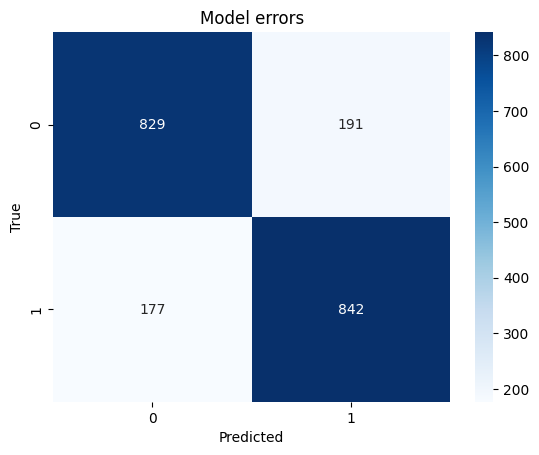


Misclassified Comments:
True Label: 1
Predicted Label: 0
Comment: dont tell me what to do with my body  the same people that want to enforce antiabortion laws on women

True Label: 1
Predicted Label: 0
Comment: i dont know whats in it as if they know whats in the hamburgers they eat the milk they drink the high fructose corn syrup they consume what a tragedy of stupidity

True Label: 1
Predicted Label: 0
Comment: i trust my immune system just translates to i dont know how vaccines work

True Label: 0
Predicted Label: 1
Comment: vaccines are saving lives meanwhile romania being the least vaccinated and also least infected country in the whole europe

True Label: 0
Predicted Label: 1
Comment: we take other risks so taking this one shouldnt be a problem is the dumbest argument there is



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train the classifier
classifier = LogisticRegression(solver='liblinear',C=2.621225946900473,penalty='l2')
classifier.fit(X_train_vectorized, y_train)

# Predict labels for the test set
y_pred = classifier.predict(X_test_vectorized)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\n\n")
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Model errors')
plt.show()

misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]

# Print some examples of misclassified comments
print("\nMisclassified Comments:")
for idx in misclassified_indices[:5]:  
    try:
        print("True Label:", y_test.iloc[idx])
        print("Predicted Label:", y_pred[idx])
        print("Comment:", X_test.iloc[idx])
        print()
    except KeyError as e:
        print("Error accessing comment at index", idx, ":", e)

**Inspecting feature importance within selected missed predictions:**

In [ ]:
importance = {'feature': vectorizer.get_feature_names_out(), 'coefficient' : classifier.coef_[0]}
df = pd.DataFrame(importance)

In [ ]:
print(df[df['feature'].str.fullmatch('dont|tell|me|what|to|do|with|my|body|the|same|people|that|want|to|enforce|anti|abortion|laws|on|women')])

       feature  coefficient
4     abortion    -0.826070
152       anti     4.316814
379       body    -2.823196
1010      dont    -1.989242
1125   enforce    -0.838043
1935      laws    -0.787846
2501    people     1.044739
3497      tell    -1.742466
3837      want     1.236325
3929     women    -1.345141


In [ ]:
print(df[df['feature'].str.fullmatch('i|dont|know|whats|in|it|as|if|they|know|whats|in|the|hamburgers|they|eat|the|milk|they|drink|the|high|fructose|corn|syrup|they|consume|what|a|tragedy|of|stupidity')])

        feature  coefficient
1010       dont    -1.989202
1030      drink     1.381936
1064        eat    -0.336864
1608       high     0.265025
1905       know    -1.129276
2188       milk    -0.353141
3382  stupidity     3.042607
3605    tragedy     1.220017
3897      whats    -1.168518


In [ ]:
print(df[df['feature'].str.fullmatch('i|trust|my|immune|system|just|translates|to|i|dont|know|how|vaccines|work')])

       feature  coefficient
1010      dont    -1.989202
1706    immune    -2.164161
1879      just     1.461553
1905      know    -1.129276
3642     trust    -0.996591
3755  vaccines     1.609728
3939      work     0.896604


In [ ]:
print(df[df['feature'].str.fullmatch("vaccines|are|saving|lives|meanwhile|romania|being|the|least|vaccinated|and|also|least|infected|country|in|the|whole|europe")])

         feature  coefficient
757      country     1.864658
1156      europe     0.740655
1752    infected     0.564227
2018       lives     3.079240
3049      saving     2.434924
3747  vaccinated     3.061355
3755    vaccines     1.609728


In [ ]:
print(df[df['feature'].str.fullmatch('we|take|other|risks|so|taking|this|one|shouldnt|be|a|problem|is|the|dumbest|argument|there|is')])

       feature  coefficient
201   argument     3.374723
1047   dumbest    -0.354113
2685   problem     0.898952
2986     risks     0.066342
3158  shouldnt    -0.169929
3471    taking    -1.916628


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5c479b05-4b50-4830-87d4-a7babcee2bc9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>